## 1| Importing the necessary libraries <a class="anchor" id="libs"></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/emotion-dataset.zip','r') as zipObj:
  zipObj.extractall()

Mounted at /content/drive


In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')

## 2| Exploring the dataset <a class="anchor" id="exp"></a>

<Axes: >

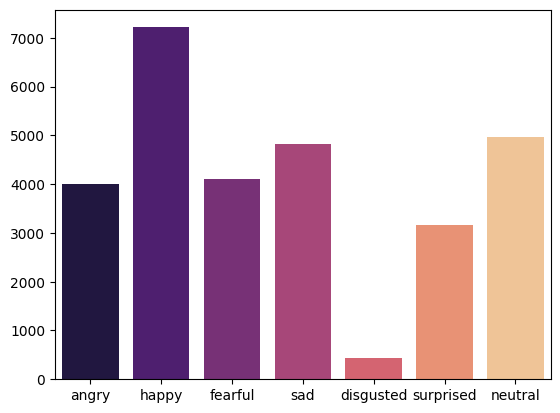

In [ ]:
train_dir = '/content/train'
emotions = os.listdir(train_dir)

train_counts = []

for emotion in emotions:
    folder = os.path.join(train_dir, emotion)
    train_counts.append(len(os.listdir(folder)))

sns.barplot(x=emotions, y=train_counts, palette='magma')

<Axes: >

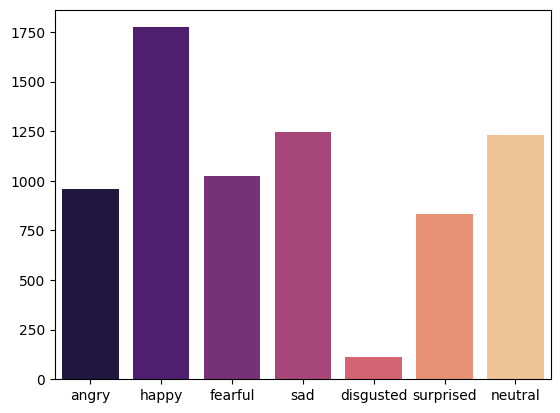

In [ ]:
test_dir = '/content/test'

test_counts = []

for emotion in emotions:
    folder = os.path.join(test_dir, emotion)
    test_counts.append(len(os.listdir(folder)))

sns.barplot(x=emotions, y=test_counts, palette='magma')

Seems like we'll have to adjust the class weights to deal with the data imbalance.

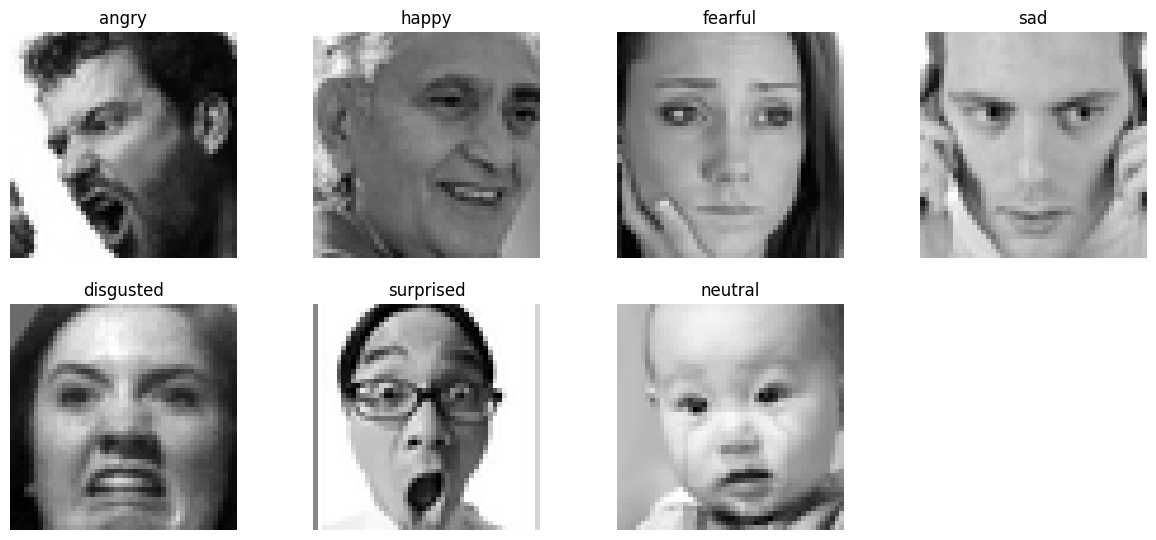

In [ ]:
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

## 3| Image data generators and augmentation <a class="anchor" id="gen"></a>

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## 4| Calculating class weights <a class="anchor" id="wghts"></a>

In [ ]:
classes = np.array(train_generator.classes)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 1.0266046844269623,
 1: 9.406618610747051,
 2: 1.0010460615781582,
 3: 0.5684387684387684,
 4: 0.8260394187886635,
 5: 0.8491274770777877,
 6: 1.293372978330405}

## 5| Transfer learning model design <a class="anchor" id="des"></a>

In [ ]:
input_shape = (224, 224, 3)

base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)

model = Sequential([
    base_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.1),
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(7, activation='softmax')
])

optimizer = Adamax(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                         

## 6| Model training <a class="anchor" id="train"></a>

In [ ]:
train_history = model.fit(
    train_generator,
    steps_per_epoch=200,
    epochs=50,
    validation_data=test_generator,
    validation_steps=100,
    class_weight=class_weights_dict
)

Epoch 1/50
200/200 [==============================] - 145s 547ms/step - loss: 1.9228 - accuracy: 0.2208 - val_loss: 1.8381 - val_accuracy: 0.2822
Epoch 2/50
200/200 [==============================] - 111s 554ms/step - loss: 1.8359 - accuracy: 0.2864 - val_loss: 1.7507 - val_accuracy: 0.3338
Epoch 3/50
200/200 [==============================] - 111s 552ms/step - loss: 1.7085 - accuracy: 0.3327 - val_loss: 1.6024 - val_accuracy: 0.4097
Epoch 4/50
200/200 [==============================] - 113s 564ms/step - loss: 1.6175 - accuracy: 0.3722 - val_loss: 1.4575 - val_accuracy: 0.4497
Epoch 5/50
200/200 [==============================] - 110s 550ms/step - loss: 1.5688 - accuracy: 0.3963 - val_loss: 1.3932 - val_accuracy: 0.4853
Epoch 6/50
200/200 [==============================] - 110s 551ms/step - loss: 1.5250 - accuracy: 0.4048 - val_loss: 1.3841 - val_accuracy: 0.4716
Epoch 7/50
200/200 [==============================] - 111s 555ms/step - loss: 1.4555 - accuracy: 0.4403 - val_loss: 1.3407 -

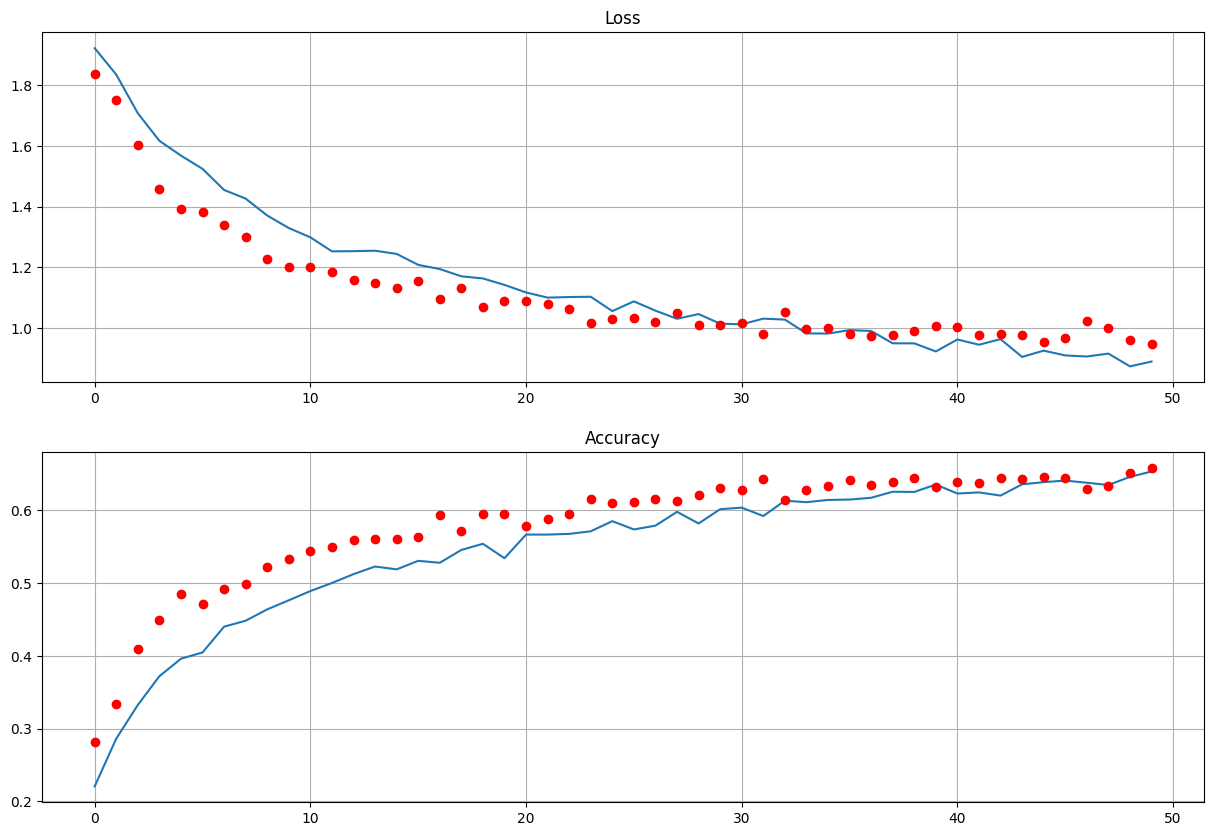

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'], 'ro')
plt.title('Loss')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'], 'ro')
plt.title('Accuracy')
plt.grid(True)

## 7| Model Evaluation <a class="anchor" id="eval"></a>

In [ ]:
# redefining the test generator so it doesnt shuffle
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes=list(test_generator.class_indices.keys())

Found 7178 images belonging to 7 classes.
225/225 [==============================] - 22s 93ms/step


In [ ]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.61      0.54      0.58       958
           1       0.66      0.71      0.68       111
           2       0.49      0.35      0.41      1024
           3       0.87      0.85      0.86      1774
           4       0.57      0.68      0.62      1233
           5       0.52      0.51      0.51      1247
           6       0.68      0.84      0.75       831

    accuracy                           0.65      7178
   macro avg       0.63      0.64      0.63      7178
weighted avg       0.64      0.65      0.64      7178



Text(0.5, 1.0, 'Confusion Matrix')

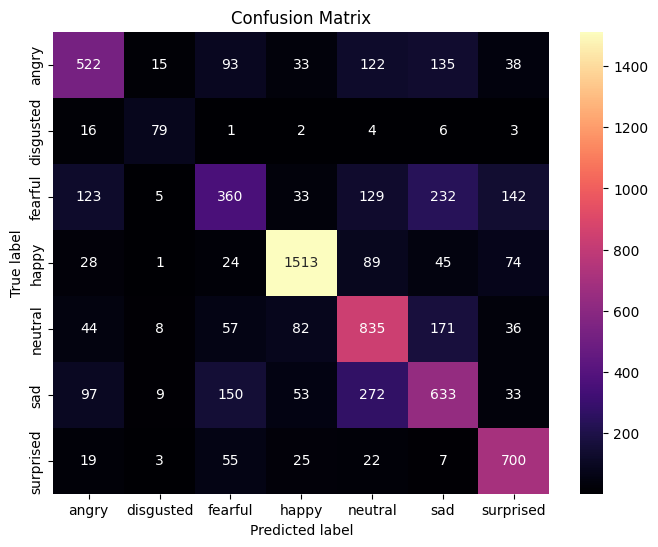

In [ ]:
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="magma", xticklabels=classes, yticklabels=classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')

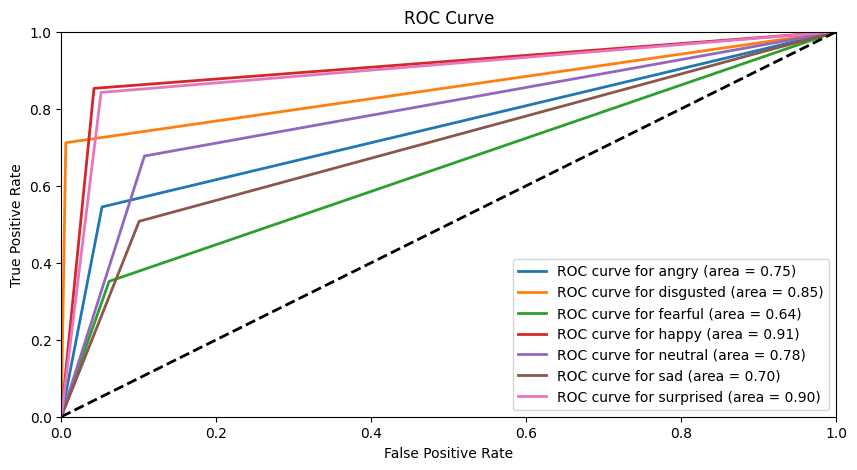

In [ ]:
y_encoded = pd.get_dummies(true_labels).astype(int).values
preds_encoded = pd.get_dummies(pred_labels).astype(int).values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:,i], preds_encoded[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

In [ ]:
model.save('EmotionDetector.h5')

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

225/225 [==============================] - 21s 92ms/step - loss: 0.9649 - accuracy: 0.6467
Test Loss: 0.96485835313797
Test Accuracy: 0.6466982364654541


## Conclusion <a class="anchor" id="con"></a>

The results are a little less that I hoped for, but that's okay. The main goal of this notebook was to test out transfer learning and it does indeed help a whole lot but picking the right network takes some trial and error. Overall, this project had been a fun experience.

If you have any questions or recommendations feel free to comment, and I hope you found this notebook helpful.